In [15]:
import math
import numpy as np
!pip3 install matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.3/7.3 MB 1.3 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 1.7 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.2/63.2 kB 3.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 229.7/229.7 kB 5.1 MB/s eta 0:00:0000:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.3/98.3 kB 5.0 MB/s eta 0:00:00


In [4]:
def f(x):
    return 3*x**2 -4*x + 5


In [5]:
f(3.0)

20.0

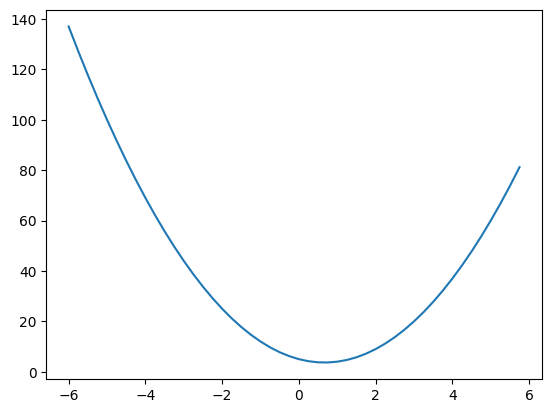

In [8]:
xs = np.arange(-6,6,0.25)
plt.plot(xs,f(xs))

In [15]:
# Dreivative of f(x)

h = 0.00000001
x = 3.0
y = -3.0
z = 2/3
print((f(x+h) - f(x))/h)   # slope formula
print((f(y+h) - f(y))/h)
print((f(z+h) - f(z))/h)


14.00000009255109
-22.00000039920269
0.0


In [24]:
h = 0.00000001

a = 2.0
b = -3.0
c = 10.0

d1 = a * b + c
c += h  # keep changing the var to a,b,c then see the changes to the function
d2 = a * b + c

print(d1)
print(d2)
print("slope : ", (d2 - d1)/h)

4.0
4.000000010000001
slope :  1.000000082740371


In [16]:
class Value:
  
  def __init__(self, data, _children=(), _op='', label=''):
    self.data = data
    self.grad = 0.0
    self._backward = lambda: None
    self._prev = set(_children)
    self._op = _op
    self.label = label

  def __repr__(self):
    return f"Value(data={self.data})"
  
  def __add__(self, other):
    other = other if isinstance(other, Value) else Value(other)
    out = Value(self.data + other.data, (self, other), '+')
    
    def _backward():
      self.grad += 1.0 * out.grad
      other.grad += 1.0 * out.grad
    out._backward = _backward
    
    return out

  def __mul__(self, other):
    other = other if isinstance(other, Value) else Value(other)
    out = Value(self.data * other.data, (self, other), '*')
    
    def _backward():
      self.grad += other.data * out.grad
      other.grad += self.data * out.grad
    out._backward = _backward
      
    return out
  
  def __pow__(self, other):
    assert isinstance(other, (int, float)), "only supporting int/float powers for now"
    out = Value(self.data**other, (self,), f'**{other}')

    def _backward():
        self.grad += other * (self.data ** (other - 1)) * out.grad
    out._backward = _backward

    return out
  
  def __rmul__(self, other): # other * self  check wheather the opssite multiplication is possible
    return self * other  #a * 2 is possible but 2 * a is not possible without this __rrmul__!

  def __truediv__(self, other): # self / other
    return self * other**-1

  def __neg__(self): # -self
    return self * -1

  def __sub__(self, other): # self - other
    return self + (-other)

  def __radd__(self, other): # other + self
    return self + other

  def tanh(self):
    x = self.data
    t = (math.exp(2*x) - 1)/(math.exp(2*x) + 1)
    out = Value(t, (self, ), 'tanh')
    
    def _backward():
      self.grad += (1 - t**2) * out.grad
    out._backward = _backward
    
    return out
  
  def exp(self):
    x = self.data
    out = Value(math.exp(x), (self, ), 'exp')
    
    def _backward():
      self.grad += out.data * out.grad # NOTE: in the video I incorrectly used = instead of +=. Fixed here.
    out._backward = _backward
    
    return out
  
  
  def backward(self):
    
    topo = []
    visited = set()
    def build_topo(v):
      if v not in visited:
        visited.add(v)
        for child in v._prev:
          build_topo(child)
        topo.append(v)
    build_topo(self)
    
    self.grad = 1.0
    for node in reversed(topo):
      node._backward()
        

In [111]:
a = Value(2, label = 'a')
b = Value(-5,label = "b")
c = Value(23, label = "c")
e = a * b; e.label= 'e'
d = e + c; d.label ='d'
f = Value(13, label="f")
L = f * d; L.label='L'


In [112]:
L

Value(data=169)

In [113]:
d._prev

{Value(data=-10), Value(data=23)}

In [114]:
d._op

'+'

In [18]:
 from graphviz import Digraph  #Dont use pip install for this library use conda insted


def trace(root):
  # builds a set of all nodes and edges in a graph
  nodes, edges = set(), set()
  def build(v):
    if v not in nodes:
      nodes.add(v)
      for child in v._prev:
        edges.add((child, v))
        build(child)
  build(root)
  return nodes, edges

def draw_dot(root):
  dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right
  
  nodes, edges = trace(root)
  for n in nodes:
    uid = str(id(n))
    # for any value in the graph, create a rectangular ('record') node for it
    dot.node(name = uid, label = "{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape='record')
    if n._op:
      # if this value is a result of some operation, create an op node for it
      dot.node(name = uid + n._op, label = n._op)
      # and connect this node to it
      dot.edge(uid + n._op, uid)

  for n1, n2 in edges:
    # connect n1 to the op node of n2
    dot.edge(str(id(n1)), str(id(n2)) + n2._op)

  return dot

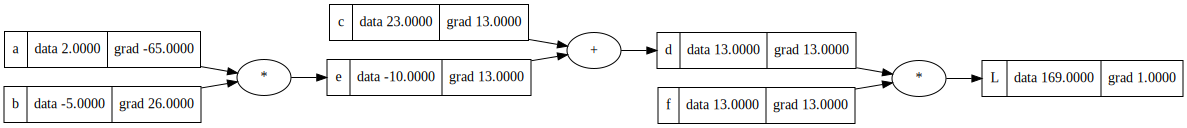

In [142]:
draw_dot(L) #Here the only vale objects are data not the operators

In [144]:
def deriv():
    h = 0.001
    a = Value(2, label = 'a')
    b = Value(-5,label = "b")
    c = Value(23, label = "c")
    e = a * b; e.label= 'e'
    d = e + c; d.label ='d'
    f = Value(13, label="f")
    L = f * d; L.label='L'
    l1 = L.data
    
    a = Value(2  , label = 'a')
    b = Value(-5,label = "b")
    c = Value(23 , label = "c")
    e = a * b; e.label= 'e'
    d = e + c; d.label ='d'
    f = Value(13, label="f")
    L = f * d; L.label='L'
    l2 = L.data + h
    
    print((l2-l1)/h)
    
deriv()



1.0000000000047748


In [143]:
d.grad = 13.00000000000523
f.grad = 13.00000000000523
a.grad = -64.99999999999773
b.grad = 26.00000000001046
e.grad = 13.00000000000523
c.grad = 13.00000000000523
L.grad = 1.0000000000047748


In [149]:
# Changing small value of variables to move towards the gradient

a.data += 0.00000001 * a.grad   # Apply only for leaf nodes
b.data += 0.00000001 * b.grad
c.data += 0.00000001 * c.grad
f.data += 0.00000001 * f.grad

# Running the forward pass

e = a * b
d = e + c
L = f * d
L



Value(data=271.36272583266924)

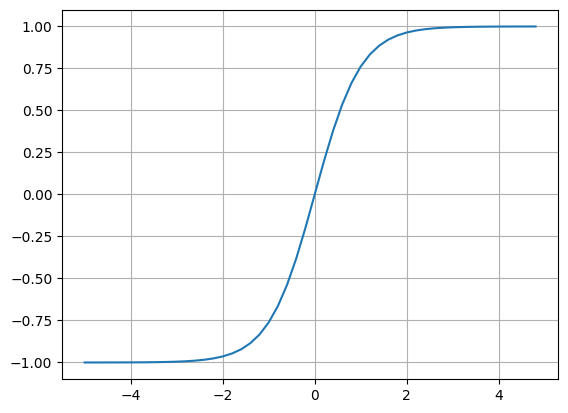

In [150]:
plt.plot(np.arange(-5,5,0.2), np.tanh(np.arange(-5,5,0.2))); plt.grid();

In [19]:
# inputs x1,x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1,w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of the neuron
b = Value(6.8813735870195432, label='b')
# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'
o = n.tanh(); o.label = 'o'

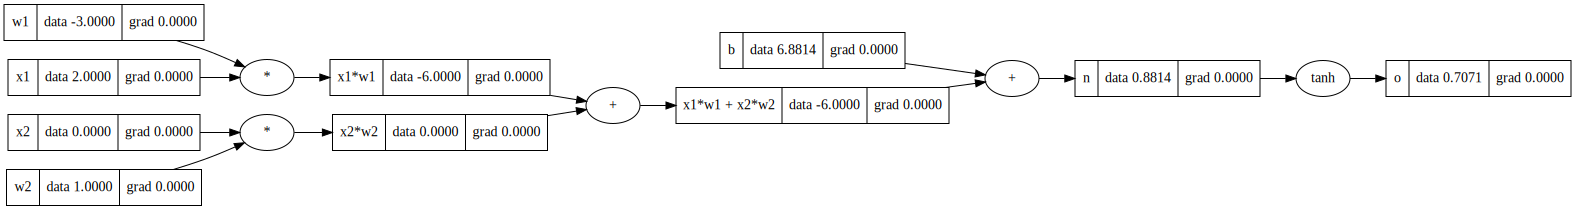

In [20]:
draw_dot(o)

## using _backward function in class to find geadientin reverse  topological order manually

In [173]:
o.grad = 1

In [177]:
o._backward()

In [179]:
n._backward()

In [181]:
x1w1x2w2._backward()

In [183]:
x1w1._backward()
x2w2._backward()

## Using backward function in class to find gradient in reverse topological order Automatically

In [187]:
o.backward()

## Exceptions

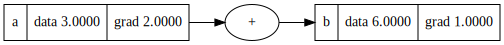

In [189]:


a = Value(3.0, label='a')
b = a + a   ; b.label = 'b'
b.backward()
draw_dot(b)

'''
        def _backward():
          self.grad = 1.0 * out.grad
          other.grad = 1.0 * out.grad
          
          By using the above step earlier we would just be rewriting the gradient. This is only happens when children nodes are same
          Instead we should add
          
        
        def _backward():
          self.grad += 1.0 * out.grad
          other.grad += 1.0 * out.grad
          
          

'''

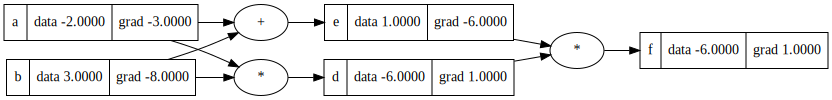

In [190]:


a = Value(-2.0, label='a')
b = Value(3.0, label='b')
d = a * b    ; d.label = 'd'
e = a + b    ; e.label = 'e'
f = d * e    ; f.label = 'f'

f.backward()

draw_dot(f)



In [4]:
!which python
!conda list

/Users/jeethu_srini/anaconda3/envs/micrograd/bin/python
# packages in environment at /Users/jeethu_srini/anaconda3/envs/micrograd:
#
# Name                    Version                   Build  Channel
anyio                     3.5.0           py310hca03da5_0  
appnope                   0.1.2           py310hca03da5_1001  
argon2-cffi               21.3.0             pyhd3eb1b0_0  
argon2-cffi-bindings      21.2.0          py310h1a28f6b_0  
asttokens                 2.0.5              pyhd3eb1b0_0  
attrs                     22.1.0          py310hca03da5_0  
babel                     2.11.0          py310hca03da5_0  
backcall                  0.2.0              pyhd3eb1b0_0  
beautifulsoup4            4.11.1          py310hca03da5_0  
blas                      1.0                    openblas  
bleach                    4.1.0              pyhd3eb1b0_0  
brotlipy                  0.7.0           py310h1a28f6b_1002  
bzip2                     1.0.8                h620ffc9_4  
ca-certificate

In [5]:
# -*- coding: utf-8 -*-
import torch
import math


class Polynomial3(torch.nn.Module):
    def __init__(self):
        """
        In the constructor we instantiate four parameters and assign them as
        member parameters.
        """
        super().__init__()
        self.a = torch.nn.Parameter(torch.randn(()))
        self.b = torch.nn.Parameter(torch.randn(()))
        self.c = torch.nn.Parameter(torch.randn(()))
        self.d = torch.nn.Parameter(torch.randn(()))

    def forward(self, x):
        """
        In the forward function we accept a Tensor of input data and we must return
        a Tensor of output data. We can use Modules defined in the constructor as
        well as arbitrary operators on Tensors.
        """
        return self.a + self.b * x + self.c * x ** 2 + self.d * x ** 3

    def string(self):
        """
        Just like any class in Python, you can also define custom method on PyTorch modules
        """
        return f'y = {self.a.item()} + {self.b.item()} x + {self.c.item()} x^2 + {self.d.item()} x^3'


# Create Tensors to hold input and outputs.
x = torch.linspace(-math.pi, math.pi, 2000)
y = torch.sin(x)

# Construct our model by instantiating the class defined above
model = Polynomial3()

# Construct our loss function and an Optimizer. The call to model.parameters()
# in the SGD constructor will contain the learnable parameters (defined 
# with torch.nn.Parameter) which are members of the model.
criterion = torch.nn.MSELoss(reduction='sum')
optimizer = torch.optim.SGD(model.parameters(), lr=1e-6)
for t in range(2000):
    # Forward pass: Compute predicted y by passing x to the model
    y_pred = model(x)

    # Compute and print loss
    loss = criterion(y_pred, y)
    if t % 100 == 99:
        print(t, loss.item())

    # Zero gradients, perform a backward pass, and update the weights.
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

print(f'Result: {model.string()}')



99 1087.081298828125
199 721.8554077148438
299 480.3392639160156
399 320.62933349609375
499 215.0157928466797
599 145.17507934570312
699 98.990234375
799 68.4486083984375
899 48.25161361694336
999 34.8953742980957
1099 26.063026428222656
1199 20.222078323364258
1299 16.3594913482666
1399 13.805092811584473
1499 12.115835189819336
1599 10.998697280883789
1699 10.259923934936523
1799 9.771324157714844
1899 9.448212623596191
1999 9.234521865844727
Result: y = 0.0010965624824166298 + 0.8369073867797852 x + -0.00018917220586445183 x^2 + -0.09050925076007843 x^3


In [6]:
!python3 --version

Python 3.10.9


In [1]:
!conda list


# packages in environment at /Users/jeethu_srini/anaconda3/envs/micrograd:
#
# Name                    Version                   Build  Channel
anyio                     3.5.0           py310hca03da5_0  
appnope                   0.1.2           py310hca03da5_1001  
argon2-cffi               21.3.0             pyhd3eb1b0_0  
argon2-cffi-bindings      21.2.0          py310h1a28f6b_0  
asttokens                 2.0.5              pyhd3eb1b0_0  
attrs                     22.1.0          py310hca03da5_0  
babel                     2.11.0          py310hca03da5_0  
backcall                  0.2.0              pyhd3eb1b0_0  
beautifulsoup4            4.11.1          py310hca03da5_0  
blas                      1.0                    openblas  
bleach                    4.1.0              pyhd3eb1b0_0  
brotlipy                  0.7.0           py310h1a28f6b_1002  
bzip2                     1.0.8                h620ffc9_4  
ca-certificates           2023.01.10           hca03da5_0  
certifi   

In [4]:
import torch 

In [5]:
x1 = torch.Tensor([2.0]).double()                ; x1.requires_grad = True   #Double for float64 precision
x2 = torch.Tensor([0.0]).double()                ; x2.requires_grad = True
w1 = torch.Tensor([-3.0]).double()               ; w1.requires_grad = True
w2 = torch.Tensor([1.0]).double()                ; w2.requires_grad = True
b = torch.Tensor([6.8813735870195432]).double()  ; b.requires_grad = True
n = x1*w1 + x2*w2 + b
o = torch.tanh(n)

print(o.data.item())
o.backward()

print('---')
print('x2', x2.grad.item())
print('w2', w2.grad.item())
print('x1', x1.grad.item())
print('w1', w1.grad.item())


0.7071066904050358
---
x2 0.5000001283844369
w2 0.0
x1 -1.5000003851533106
w1 1.0000002567688737


In [10]:
x1.shape

torch.Size([1])

In [11]:
x1.item()

2.0

In [12]:
x1.grad.item()

-1.5000003851533106

In [91]:
# Creating a MLP layer by layer
import random
class Neuron:
    def __init__(self, nin):
        self.w = [Value(random.uniform(-1, 1)) for _ in range(nin)]
        self.b = Value(random.uniform(-1, 1))
    
    def __call__(self, x):  # Use this function to feed the neuron with inputs
        activation = sum((wi*xi for wi,xi in zip(self.w,x)), self.b)
        out = activation.tanh()
        return out
    
    def parameters(self):
        return self.w + [self.b] #To fetch parameeters in a single neuron
      

class Layer:
  
      def __init__(self, nin, nout): 
        self.neurons = [Neuron(nin) for _ in range(nout)]  # For each layer initializing two neurons (for eample 2 may be more)

      def __call__(self, x):
        outs = [n(x) for n in self.neurons] 
        return outs[0] if len(outs) == 1 else outs

      def parameters(self):
        return [p for neuron in self.neurons for p in neuron.parameters()]   # To fetch parameters form neurons in a layer

class MLP:
  
      def __init__(self, nin, nouts):
        sz = [nin] + nouts
        self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))]

      def __call__(self, x):
        for layer in self.layers:
          x = layer(x)
        return x

      def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]   # To fetch parameters in all the layers

    
                

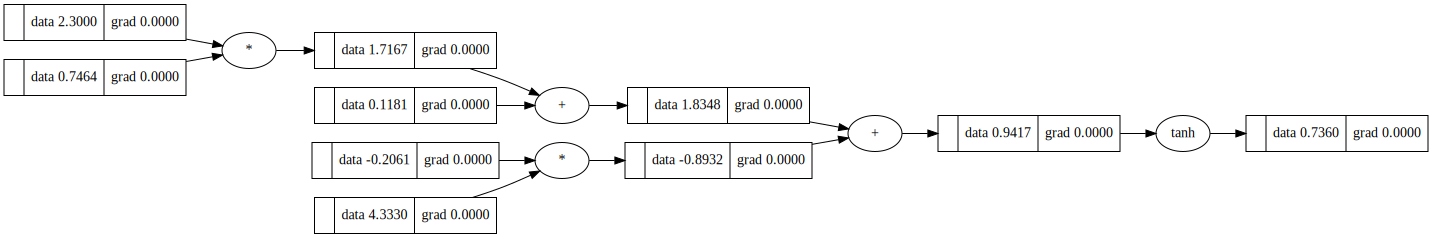

In [69]:
x = [2.3,4.333]
n = Neuron(2)
n(x)
draw_dot(n(x))

In [79]:
x = [2.3,4.333]
n = Layer(2,3)
n(x)
#draw_dot(i for i in n(x)) not working


[Value(data=-0.9981038917898376),
 Value(data=-0.8622484710996042),
 Value(data=0.6871111780955076)]

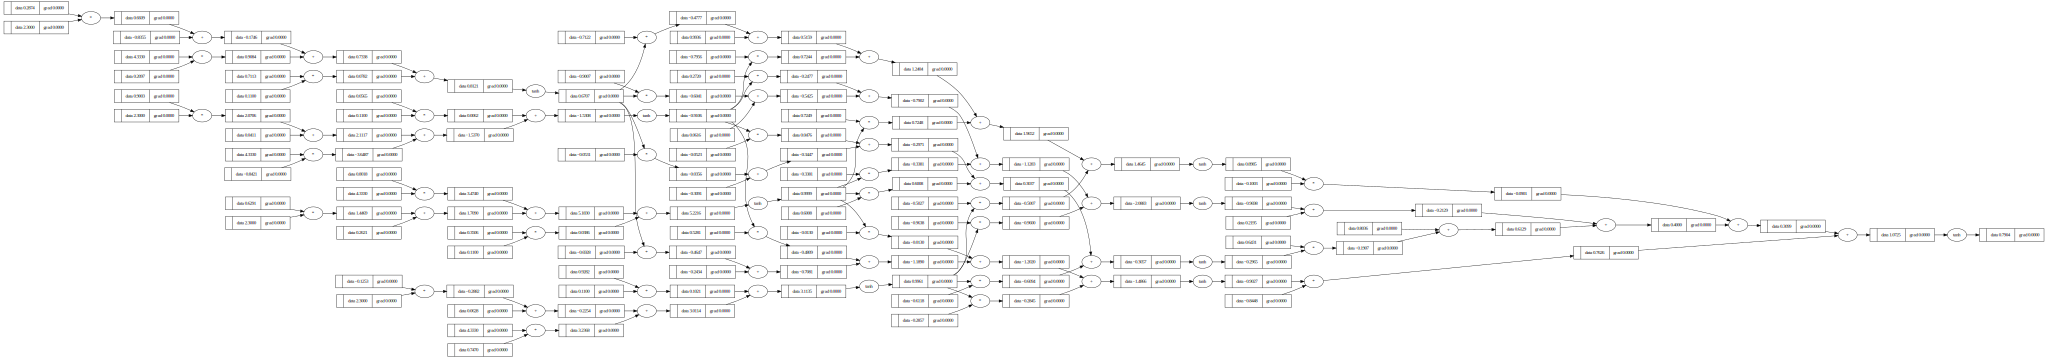

In [90]:
x = [2.3,4.333,0.11]
n = MLP(3, [4,4,1])
draw_dot(n(x))


In [99]:
xs = [
  [2.0, 3.0, -1.0],
  [3.0, -1.0, 0.5],
  [0.5, 1.0, 1.0],
  [1.0, 1.0, -1.0],
]
ys = [1.0, -1.0, -1.0, 1.0] # desired targets


In [311]:
for k in range(20):
    
  # forward pass
  ypred = [n(x) for x in xs]
  loss = sum((yout - ygt)**2 for ygt, yout in zip(ys, ypred)) # A Normal loss functions
  
  # backward pass
  for p in n.parameters():
    p.grad = 0.0
  loss.backward()
  
  # update
  for p in n.parameters():
    p.data += -0.05 * p.grad    # Indicating the step size
  
  print(k, loss.data)
  
  

0 9.43987282822151e-05
1 9.437817624995193e-05
2 9.435763314433722e-05
3 9.433709895955545e-05
4 9.431657368980638e-05
5 9.429605732929103e-05
6 9.427554987220924e-05
7 9.425505131277307e-05
8 9.423456164519656e-05
9 9.421408086370195e-05
10 9.419360896251258e-05
11 9.417314593585703e-05
12 9.415269177797353e-05
13 9.41322464831012e-05
14 9.411181004548291e-05
15 9.409138245936705e-05
16 9.40709637190127e-05
17 9.405055381867596e-05
18 9.403015275263105e-05
19 9.400976051513019e-05


In [301]:
n.parameters()  #List of all weights...

[Value(data=0.29804817527584593),
 Value(data=0.1078341570924154),
 Value(data=0.6312940553323918),
 Value(data=-0.8923425278049246),
 Value(data=0.6863754460387435),
 Value(data=-0.8885973661703991),
 Value(data=0.9968581217285564),
 Value(data=0.2002647434745413),
 Value(data=0.5577134684098788),
 Value(data=0.8117723052936072),
 Value(data=0.3124869846349553),
 Value(data=0.2262535126994233),
 Value(data=0.3127773399065993),
 Value(data=-0.2874273438571527),
 Value(data=1.579881115595217),
 Value(data=0.09535348512531763),
 Value(data=-0.2736944927039945),
 Value(data=-0.764096087013447),
 Value(data=0.3755096355303726),
 Value(data=-0.9759322799712757),
 Value(data=-0.5729795068926434),
 Value(data=-0.9755927109416169),
 Value(data=-0.08691196058679661),
 Value(data=-0.3844561069695012),
 Value(data=-1.0962674125215766),
 Value(data=0.00010578037746944679),
 Value(data=-0.7110675816803373),
 Value(data=-0.7281958026767449),
 Value(data=0.8158421582113865),
 Value(data=-0.4364749931

In [312]:
print(f"{ys} \n{ypred}") # Final results!!!

[1.0, -1.0, -1.0, 1.0] 
[Value(data=0.9960080958636405), Value(data=-0.9960305185888257), Value(data=-0.9941321552701364), Value(data=0.9947192730203314)]
